# ColdFusion
### GPR-LIDAR-FUSION
7/12/22

Query the SnowEx database to extract ground based snow depth measurements, snow pit density, GPR tracks, and Lidar point clounds where there is spatial and temporal overlap in a defined area.

Use the lidar snow depth measurements to inform the GPR density estimate to get SWE.

Test these density/SWE estimates against snowpit values

In [1]:
# Imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas
from snowexsql.db import get_table_attributes

import datetime 
from sqlalchemy import inspect
from sqlalchemy.sql import func
from sqlalchemy import Float
import shapely.geometry
from geoalchemy2.shape import from_shape
import geoalchemy2.functions as gfunc

# Imports for Lidar raster
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

### Specify Inputs

In [2]:
# Desired Magnaprobe sample dates 
depth1_date1 = datetime.date(2020,2,1) # Corresponds to ASO flight on 2/2/2020 (lidar1)
depth2_date1 = datetime.date(2020,2,12) # Corresponds to ASO flight on 2/13/2020 (lidar1)

# Desired snow pit sample dates 
density1_date1 = datetime.date(2020,1,28)
density1_date2 = datetime.date(2020,2,2) 

density2_date1 = datetime.date(2020,2,4)
density2_date2 = datetime.date(2020,2,13) 


### Define Boundingbox

In [3]:
# How to pull out ALL point data from the database that falls within our box
bbox_WSEN = 742000, 4322000, 747000, 4325000 # EPSG 26912?
x1, y1, x2, y2 = bbox_WSEN
polygon = shapely.geometry.Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]]) # used box() before
wkb_element = from_shape(polygon, srid=26912) # which srid is right?

### Magnaprobe Data

#### Lidar Date 1

In [4]:
# Instrument name 
site_name = "Grand Mesa"
instrument = "magnaprobe" 

# Get a session
engine, session = get_db(db_name)

# Find the magnaprobe PointData in the defined area within the given dates 
query_mp = session.query(PointData.geom, PointData.easting, PointData.northing, PointData.date, PointData.value, 
                    PointData.type, PointData.instrument)

# Filter by site
query_mp = query_mp.filter(PointData.site_name == site_name)
# Filter by bounding box 
query_mp = query_mp.filter(gfunc.ST_Within(PointData.geom, wkb_element))
# Filter by an instrument 
query_mp = query_mp.filter(PointData.instrument == instrument) # .in_(['magnaprobe', 'pit_ruler']))

# Slicing the dataset for specified dates 
query_mp = query_mp.filter(PointData.date == depth1_date1)

# Execute the query and convert to geopandas in one handy function
df_mp_lidar1 = query_to_geopandas(query_mp, engine) #directly pass to geopandas dataframe

# How many did were retrieved 
print(f'{len(df_mp_lidar1.index)} Magnaprobe records returned for {depth1_date1}')

session.close()

4175 Magnaprobe records returned for 2020-02-01


#### Lidar Date 2

In [5]:
# Get a session
engine, session = get_db(db_name)

# Find the magnaprobe PointData in the defined area within the given dates 
query_mp = session.query(PointData.geom, PointData.easting, PointData.northing, PointData.date, PointData.value, 
                    PointData.type, PointData.instrument)

# Filter by site
query_mp = query_mp.filter(PointData.site_name == site_name)
# Filter by bounding box 
query_mp = query_mp.filter(gfunc.ST_Within(PointData.geom, wkb_element))
# Filter by an instrument 
query_mp = query_mp.filter(PointData.instrument == instrument) # .in_(['magnaprobe', 'pit_ruler']))

# Slicing the dataset for specified dates 
query_mp = query_mp.filter(PointData.date == depth2_date1)

# Execute the query and convert to geopandas in one handy function
df_mp_lidar2 = query_to_geopandas(query_mp, engine) #directly pass to geopandas dataframe

# How many did were retrieved 
print(f'{len(df_mp_lidar2.index)} records returned for {depth2_date1}')

session.close()

998 records returned for 2020-02-12


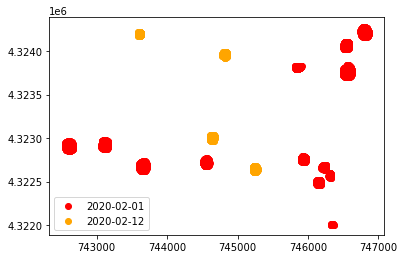

In [98]:
# Plot sites
plt.scatter(df_mp_lidar1['easting'], df_mp_lidar1['northing'], c = 'red', zorder = 10, label = str(depth1_date1))
plt.scatter(df_mp_lidar2['easting'], df_mp_lidar2['northing'], c = 'orange', zorder = 1, label = str(depth2_date1))
plt.legend()

### Snow Pit measurements

#### GPR Date Range 1

In [6]:
# Start the session
engine, session = get_db(db_name)

# Find the snowpit LayerData in the defined area within given dates
query_sp = session.query(LayerData.geom, LayerData.easting, LayerData.northing, LayerData.date, LayerData.value, 
                         LayerData.pit_id, LayerData.type, LayerData.instrument)

# Filter by site (probably not needed)
# query_sp = query_sp.filter(LayerData.site_name == 'Grand Mesa')
# Filter by bounding box
query_sp = query_sp.filter(gfunc.ST_Within(LayerData.geom, wkb_element))
# Filter by type (pit density)
query_sp = query_sp.filter(LayerData.type == "density")
# Filter by instrument 
query_sp = query_sp.filter(LayerData.instrument==None)

# Slicing the dataset for specified dates 
query_sp = query_sp.filter(LayerData.date >= density1_date1)
query_sp = query_sp.filter(LayerData.date <= density1_date2)

count_meas = query_sp.count() 
print(count_meas, " Snowpit density measurements returned!\n") 

# convert to pandas dataframe  
df_sp_gpr1 = query_to_pandas(query_sp, engine)  

# create list of the unique dates (LayerData will have a lot of repeated dates, we only need a list per visit, not per measurement)
locations = sorted(df_sp_gpr1['pit_id'].unique())
count_pits = len(locations) 
print(count_pits, " Snowpit density locations returned!\n") 

session.close()

/tmp/ipykernel_8154/4030151860.py:21: SAWarning: UserDefinedType Geometry(geometry_type='POINT') will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  count_meas = query_sp.count()
/tmp/ipykernel_8154/4030151860.py:21: SAWarning: Class ST_Within will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which wi

896  Snowpit density measurements returned!

47  Snowpit density locations returned!



In [8]:
# List unique dates
print(f' Between {density1_date1} and {density1_date2}, unique dates are {(df_sp_gpr1.date.sort_values().unique())}')

 Between 2020-01-28 and 2020-02-02, unique dates are [datetime.date(2020, 1, 28) datetime.date(2020, 1, 29)
 datetime.date(2020, 1, 30) datetime.date(2020, 1, 31)
 datetime.date(2020, 2, 1)]


#### GPR Date Range 2

In [7]:
# Start the session
engine, session = get_db(db_name)

# Find the snowpit LayerData in the defined area within given dates
query_sp = session.query(LayerData.geom, LayerData.easting, LayerData.northing, LayerData.date, LayerData.value, 
                         LayerData.pit_id, LayerData.type, LayerData.instrument)

# Filter by site (probably not needed)
# query_sp = query_sp.filter(LayerData.site_name == 'Grand Mesa')
# Filter by bounding box
query_sp = query_sp.filter(gfunc.ST_Within(LayerData.geom, wkb_element))
# Filter by type (pit density)
query_sp = query_sp.filter(LayerData.type == "density")
# Filter by instrument 
query_sp = query_sp.filter(LayerData.instrument==None)

# Slicing the dataset for specified dates 
query_sp = query_sp.filter(LayerData.date >= density2_date1)
query_sp = query_sp.filter(LayerData.date <= density2_date2)

count_meas = query_sp.count() 
print(count_meas, " Snowpit density measurements returned!\n") 

# convert to pandas dataframe  
df_sp_gpr2 = query_to_pandas(query_sp, engine)  

# create list of the unique dates (LayerData will have a lot of repeated dates, we only need a list per visit, not per measurement)
locations = sorted(df_sp_gpr2['pit_id'].unique())
count_pits = len(locations) 
print(count_pits, " Snowpit density locations returned!\n") 

session.close()

/tmp/ipykernel_8154/3867928000.py:21: SAWarning: UserDefinedType Geometry(geometry_type='POINT') will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  count_meas = query_sp.count()


1059  Snowpit density measurements returned!

57  Snowpit density locations returned!



In [26]:
# List unique dates
print(f' Between {density2_date1} and {density2_date2}, unique dates are {(df_sp_gpr2.date.sort_values().unique())}')

# Print to CSV
# df_sp_gpr2.to_csv('snow_pit_gpr2.csv')
# print('success')

 Between 2020-02-04 and 2020-02-13, unique dates are [datetime.date(2020, 2, 4) datetime.date(2020, 2, 5)
 datetime.date(2020, 2, 6) datetime.date(2020, 2, 8)
 datetime.date(2020, 2, 9) datetime.date(2020, 2, 10)
 datetime.date(2020, 2, 11) datetime.date(2020, 2, 12)]
success


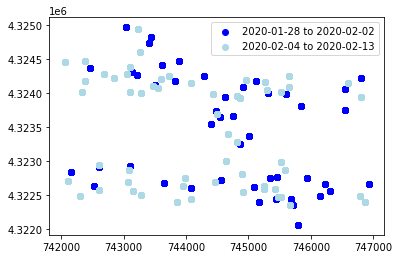

In [108]:
# Plot sites
plt.scatter(df_sp_gpr1['easting'], df_sp_gpr1['northing'], c = 'b', label = (f'{density1_date1} to {density1_date2}'))
plt.scatter(df_sp_gpr2['easting'], df_sp_gpr2['northing'], c = 'lightblue', label = (f'{density2_date1} to {density2_date2}'))
plt.legend()

In [22]:
# Attempt to extract snow pit depth data 
# # Get a session
# engine, session = get_db(db_name)

# # Find the magnaprobe PointData in the defined area within the given dates 
# query_mp = session.query(PointData.geom, PointData.easting, PointData.northing, PointData.date, 
#                          PointData.value, PointData.type, PointData.instrument, PointData.site_id) 

# # Filter by bounding box 
# query_mp = query_mp.filter(gfunc.ST_Within(PointData.geom, wkb_element))
# # Filter by an instrument 
# query_mp = query_mp.filter(PointData.instrument == 'pit ruler') 
# query_mp = query_mp.filter(PointData.type == 'depth') 

# # Slicing the dataset for specified dates 
# query_sp = query_sp.filter(PointData.date >= density1_date1)
# query_sp = query_sp.filter(PointData.date <= density1_date2)

# depths_sp = query_to_pandas(query_mp, engine)  

# # df_sp_gpr2.date.sort_values().unique()

# # result = session.query(PointData.instrument).distinct().all()

# # print('\Data Types: ', result)

In [23]:
# print(depths_sp.head())

                                                geom        easting  \
0  010100002020690000a3d1753078c12641e63af83d0e7d...  745660.094649   
1  010100002020690000090eca7b64ca264143ccc08ddf7e...  746802.241776   
2  010100002020690000589c1742b8b92641d8befe1e137e...  744668.129086   
3  010100002020690000ac3b0f408aad264195b67efe9a7d...  743109.125116   
4  0101000020206900006a0a12c2f8b02641a5990260bb7e...  743548.379044   

       northing        date  value   type instrument site_id  
0  4.322361e+06  2020-02-04   70.0  depth  pit ruler    None  
1  4.324222e+06  2020-02-01   97.0  depth  pit ruler    None  
2  4.323404e+06  2020-02-09   98.0  depth  pit ruler    None  
3  4.322924e+06  2020-02-01  100.0  depth  pit ruler    None  
4  4.324078e+06  2020-02-11   68.0  depth  pit ruler    None  


#### Average density values for GPR 1 snowpits 

In [121]:
df_sp_gpr1['value'] = df_sp_gpr1['value'].astype(float)
avgrho_sp1 = df_sp_gpr1[['pit_id', 'date', 'value', 'easting', 'northing']] 
avgrho_sp1 = avgrho_sp1.groupby(['pit_id','date']).mean() 
print(f'Number of Snow Pits = {len(avgrho_sp1)}')

Number of Snow Pits = 47


#### Average density values for GPR 2 snowpits 

In [122]:
df_sp_gpr2['value'] = df_sp_gpr2['value'].astype(float)
avgrho_sp2 = df_sp_gpr2[['pit_id', 'date', 'value', 'easting', 'northing']] 
avgrho_sp2 = avgrho_sp2.groupby(['pit_id','date']).mean() 
print(f'Number of Snow Pits = {len(avgrho_sp2)}')

Number of Snow Pits = 57


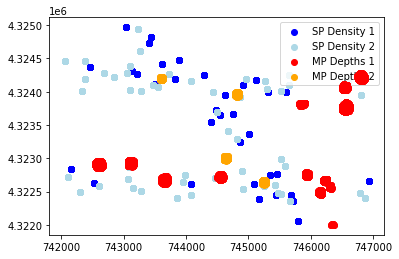

In [135]:
# Plot sites
plt.scatter(df_sp_gpr1['easting'], df_sp_gpr1['northing'], c = 'b', label = ('SP Density 1'))# {density1_date1} to {density1_date2}'))
plt.scatter(df_sp_gpr2['easting'], df_sp_gpr2['northing'], c = 'lightblue', label = ('SP Density 2'))# {density2_date1} to {density2_date2}'))
plt.scatter(df_mp_lidar1['easting'], df_mp_lidar1['northing'], c = 'red', zorder = 10, label = 'MP Depths 1')#+str(depth1_date1))
plt.scatter(df_mp_lidar2['easting'], df_mp_lidar2['northing'], c = 'orange', zorder = 1, label = 'MP Depths 2')#+str(depth2_date1))
plt.legend(loc = 'upper right')

In [ ]:
# avgrho_sp = df_sp[['easting', 'northing', 'pit_id', 'value']]
# print(avgrho_sp.head())

# avgrho_sp = df_sp.groupby(['pit_id']).mean()
# print(avgrho_sp.head())


# Average Snowpit density measurements
# Request the average (avg) of Layer data casted as a float. We have to cast to a float in the layer table because all main values are stored as a string to
# ...accommodate the hand hardness.
qry = session.query(func.avg(LayerData.value.cast(Float)))
# # Filter our query only to density
query_sp = query_sp.filter(gfunc.ST_Within(LayerData.geom, wkb_element))
qry = qry.filter(LayerData.type=='density')
qry = qry.filter(LayerData.instrument==None)
query_sp = query_sp.filter(LayerData.date >= date1)
query_sp = query_sp.filter(LayerData.date <= date2)

In [ ]:
# Request the data
rho_avg_all = qry.all()
# Request the Average Density of Just 1S1
rho_avg_1s1 = qry.filter(LayerData.site_id == '2N12').limit(1)
# This is a gotcha. The data in layer data only is stored as a string to accommodate the hand hardness values
print(f"Average density of all pits is {rho_avg_all[0][0]:0.0f} kg/m3")
print(f"Average density of pit 2N12 is {rho_avg_1s1[0][0]:0.0f} kg/m3")

# Cast Densities to float
rho_avg_all = float(rho_avg_all[0][0])
rho_avg_1s1 = float(rho_avg_1s1[0][0])

# # Can use LayerData.pit_id to average over

### GPR Data

In [ ]:
# # Get the GPR Dates

# # Start the session
# engine, session = get_db(db_name)

# # Define the GPR instrument identifier
# bsu_gpr_instrument_name = "pulse EKKO Pro multi-polarization 1 GHz GPR"

# # Query the Pointdata to isolate by GPR instrument
# query = session.query(PointData.date)
# query = query.filter(PointData.instrument == bsu_gpr_instrument_name)

# # convert to pandas dataframe  
# df = query_to_pandas(query, engine)  

# # create list of the unique dates (LayerData will have a lot of repeated dates, we only need a list per visit, not per measurement)
# GPR_dates = sorted(df['date'].unique())

# # Print the given dates
# print(GPR_dates)

# session.close()

In [ ]:
# # Start the session
# engine, session = get_db(db_name)

# # Limit the size of the GPR data for initial processing and plot
# query = session.query(PointData)
# query = query.filter(PointData.instrument == bsu_gpr_instrument_name)
# query = query.distinct().order_by(func.random()).limit(100) #all()

# bsu_gpr_sample = query_to_geopandas(query, engine)

# bsu_gpr_sample.plot()

# session.close()

### Lidar Raster (In-Progress)

In [ ]:
# Start the session
engine, session = get_db(db_name)

query = session.query(ImageData.units)
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.distinct()
result = query.all()
print(result)

session.close()